In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE, plot_ale

import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pylab as pl


plt.rcParams.update({'font.size': 18})

# print the JS visualization code to the notebook
shap.initjs()

Import the skew_bridge database

In [2]:
data1 = pd.read_excel('SkewBridge_2Col_Database_v0.xlsx', sheet_name='COL')
data1.head()

,Sim,EQ,Sa10,Eqdir,fc,fy,Lm,Ls2Lm,Wd,Lc,...,Nspan,EDP,Unnamed: 28,COL,ABP,ABA,ABT,UST,BRG,Unnamed: 35
0,1,1,-1.768922,1,3.397886,6.134044,3.316626,-0.702407,2.990044,2.147912,...,2,-0.687105,NaN,-0.687105,3.149311,3.460221,3.504325,4.102875,3.853588,1
1,2,2,-0.849313,1,3.497558,6.198634,4.099415,-0.348695,2.777936,1.724100,...,2,2.862372,NaN,2.862372,2.464704,3.460346,5.177223,4.515202,5.096568,2
2,3,3,-0.810957,2,3.465500,6.177613,3.953637,-0.045222,2.989842,2.075455,...,2,1.460567,NaN,1.460567,3.983264,3.785689,4.930509,4.819233,5.018537,3
3,4,4,-1.014436,2,3.335612,6.094850,3.933913,-0.065393,2.978069,1.665033,...,2,1.544707,NaN,1.544707,2.873734,3.594514,4.879311,4.414893,4.691440,4
4,5,5,-1.013933,2,3.611960,6.275516,3.282610,-0.737920,2.806264,1.967175,...,2,0.729865,NaN,0.729865,2.812110,3.523268,4.527609,3.673715,3.878714,5


In [3]:
len(data1)

949

In [4]:
data=data1.loc[:, 'Sa10':'EDP']
data.head()

,Sa10,Eqdir,fc,fy,Lm,Ls2Lm,Wd,Lc,ρc,sh,...,Kb,COF,ζ,mass,ΔgL,ΔgT,Ash,α,Nspan,EDP
0,-1.768922,1,3.397886,6.134044,3.316626,-0.702407,2.990044,2.147912,-3.582916,4.333361,...,0.079808,-0.818986,-2.953636,-0.036358,2.429231,1.459322,-0.076926,-0.015511,2,-0.687105
1,-0.849313,1,3.497558,6.198634,4.099415,-0.348695,2.777936,1.724100,-4.461487,4.566129,...,-0.417493,-1.107551,-2.949113,0.111623,2.986170,2.866508,0.161213,-0.739437,2,2.862372
2,-0.810957,2,3.465500,6.177613,3.953637,-0.045222,2.989842,2.075455,-3.665158,4.333361,...,-0.396074,-1.093246,-2.816803,0.114640,3.699512,3.543883,0.049158,-0.567427,2,1.460567
3,-1.014436,2,3.335612,6.094850,3.933913,-0.065393,2.978069,1.665033,-3.517404,4.333361,...,-1.180617,-1.827693,-3.180276,0.047557,3.428410,3.397446,-0.111701,-1.305582,2,1.544707
4,-1.013933,2,3.611960,6.275516,3.282610,-0.737920,2.806264,1.967175,-3.874700,4.333361,...,-1.111812,-1.736851,-3.035035,-0.027294,3.744077,3.559005,-0.198623,-2.010922,2,0.729865


In [5]:
# Generate X and y data
X = data.loc[:, data.columns != 'EDP']
y=data['EDP']
#X.head()

In [6]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:

import xgboost as xgb
from xgboost import plot_importance
XGB_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
XGB_model.fit(X_train, y_train)

Series.base is deprecated and will be removed in a future version


[20:47:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [8]:
# Print the MSE
mean_squared_error(y_test, XGB_model.predict(X_test))

0.27220365677658326

In [9]:
feature_names = X.columns
print(feature_names)

Index(['Sa10', 'Eqdir', 'fc', 'fy', 'Lm', 'Ls2Lm', 'Wd', 'Lc', 'ρc', 'sh',
       'KfT', 'Akf', 'KfrT', 'Ha', 'Ka', 'Soil', 'Kb', 'COF', 'ζ', 'mass',
       'ΔgL', 'ΔgT', 'Ash', 'α', 'Nspan'],
      dtype='object')


# XGBoost Importance

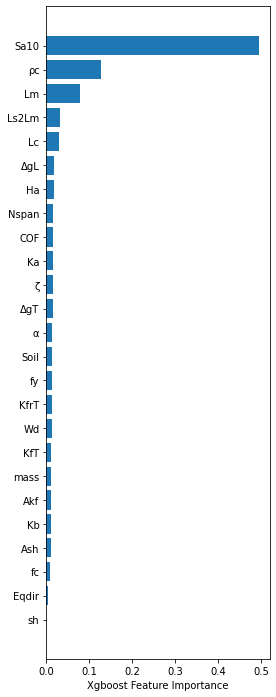

In [10]:
sorted_idx = XGB_model.feature_importances_.argsort()
plt.figure(figsize=(4,12))
plt.barh(feature_names[sorted_idx], XGB_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.savefig('skew_bridge_Xgboost_barplot.eps',format='eps', dpi=1000)


# ALE

In [11]:
XGB_ale = ALE(XGB_model.predict, feature_names=feature_names, target_names=['EDP'])

In [12]:
XGB_exp = XGB_ale.explain(X_train)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


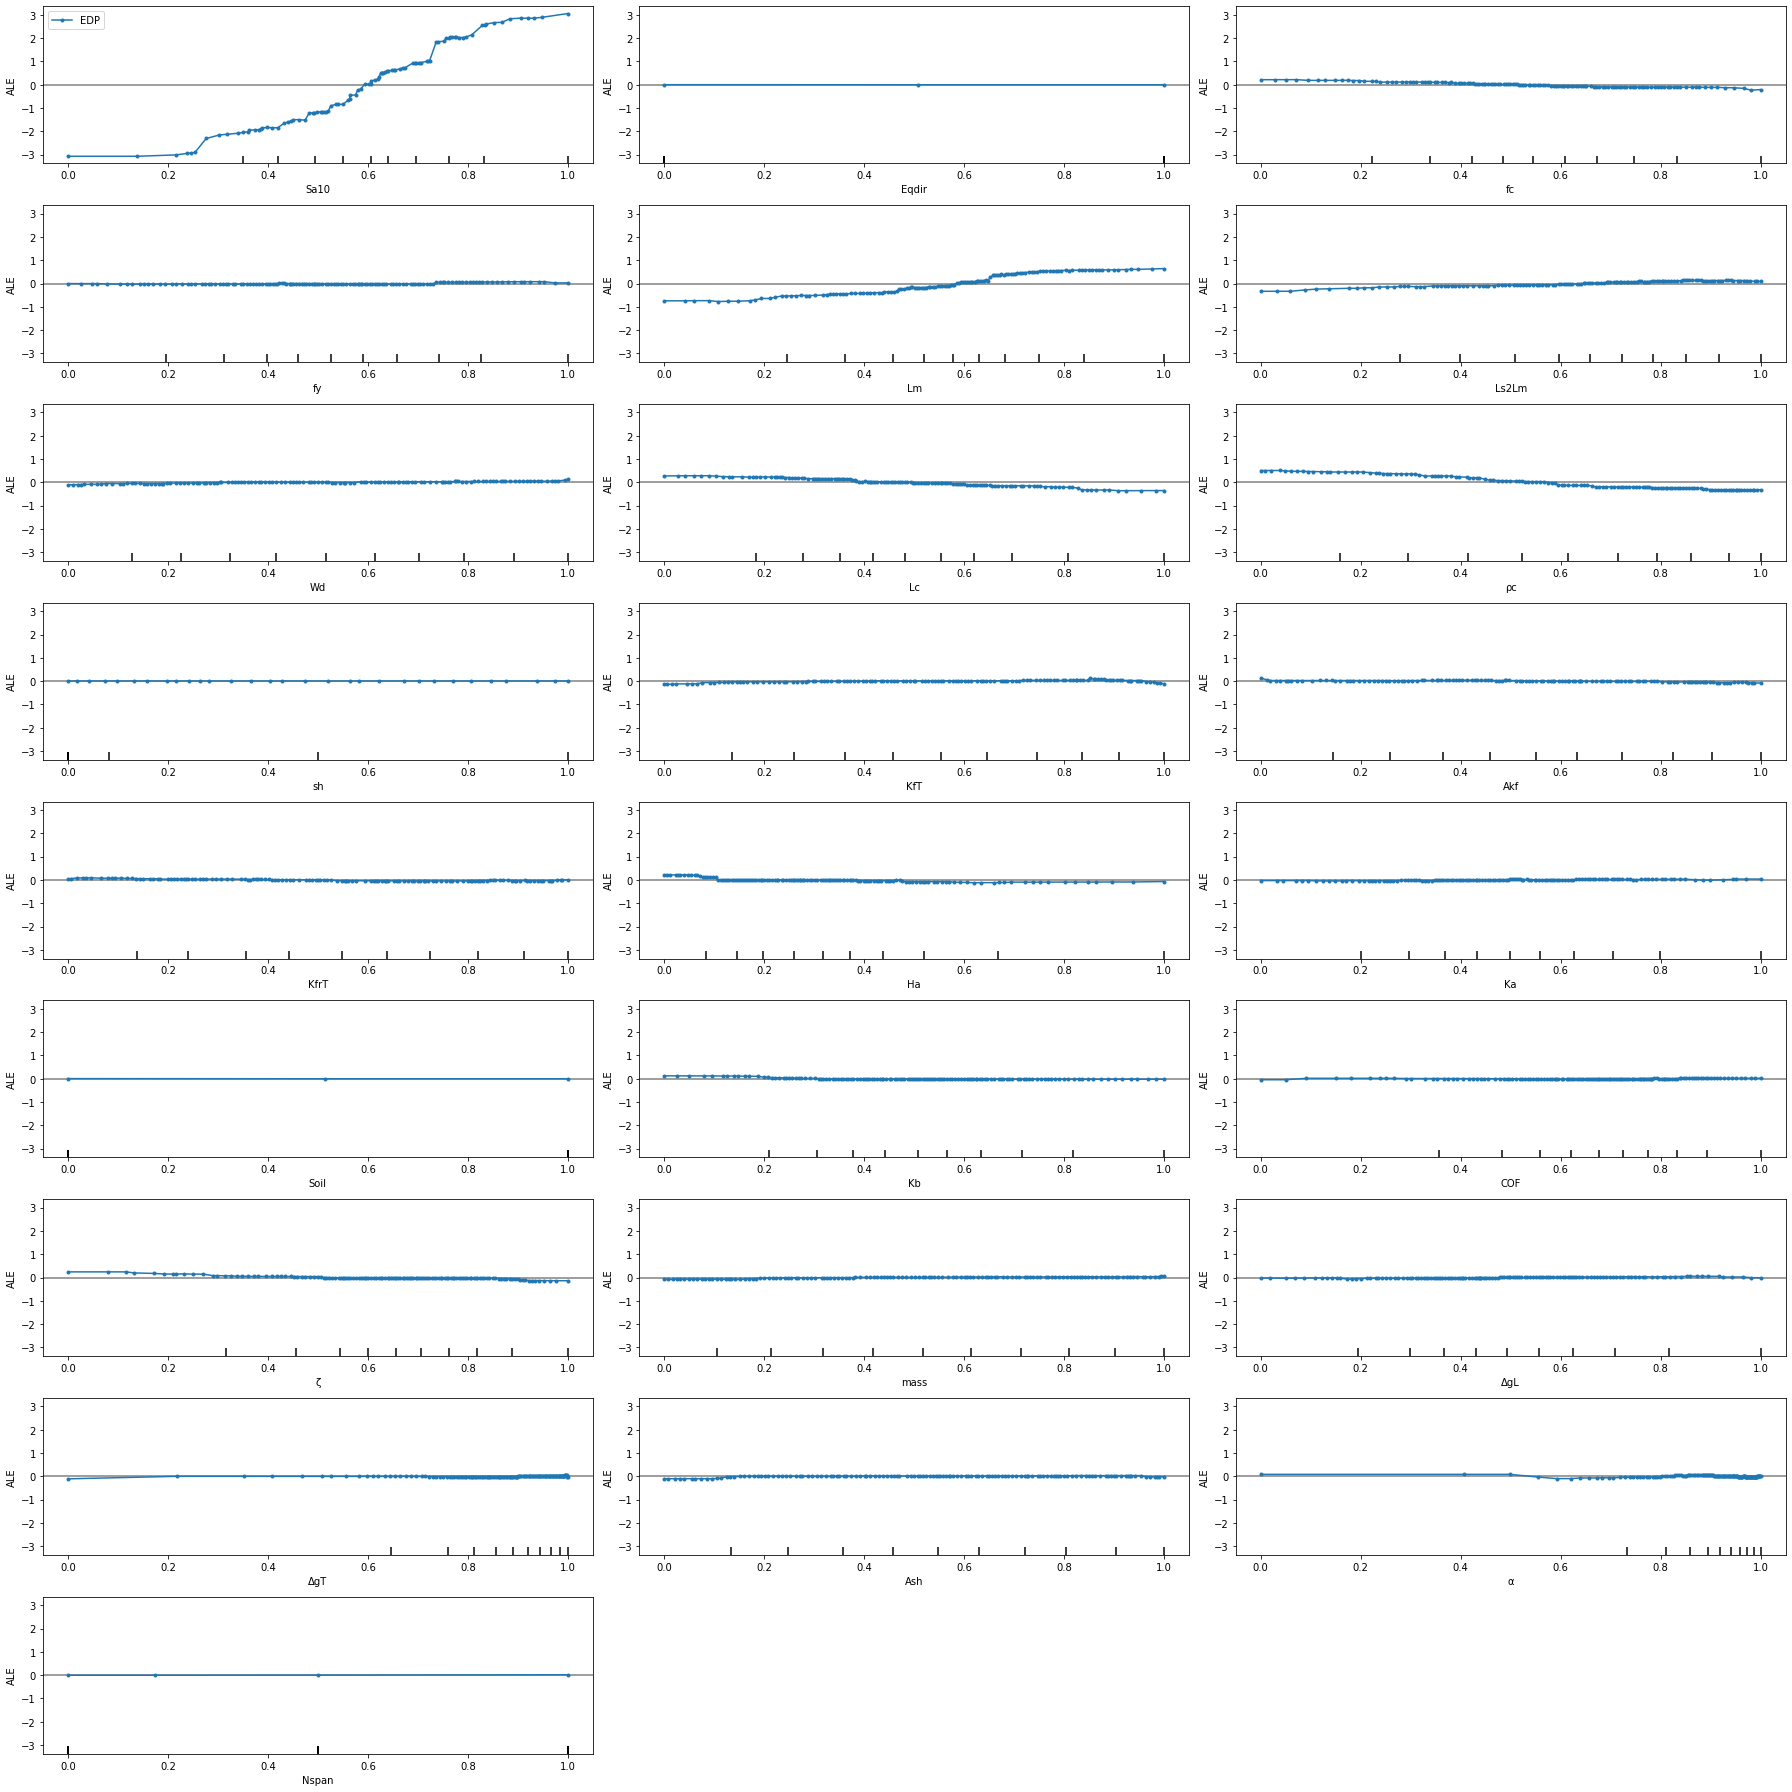

In [13]:
# ALE value is the relative feature effect on the prediction at that feature value.
plot_ale(XGB_exp, n_cols=3, fig_kw={'figwidth':25, 'figheight': 25});
plt.savefig('skew_bridge_ALE.eps',format='eps', dpi=1000)

# Partial Dependance Plots

In [14]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

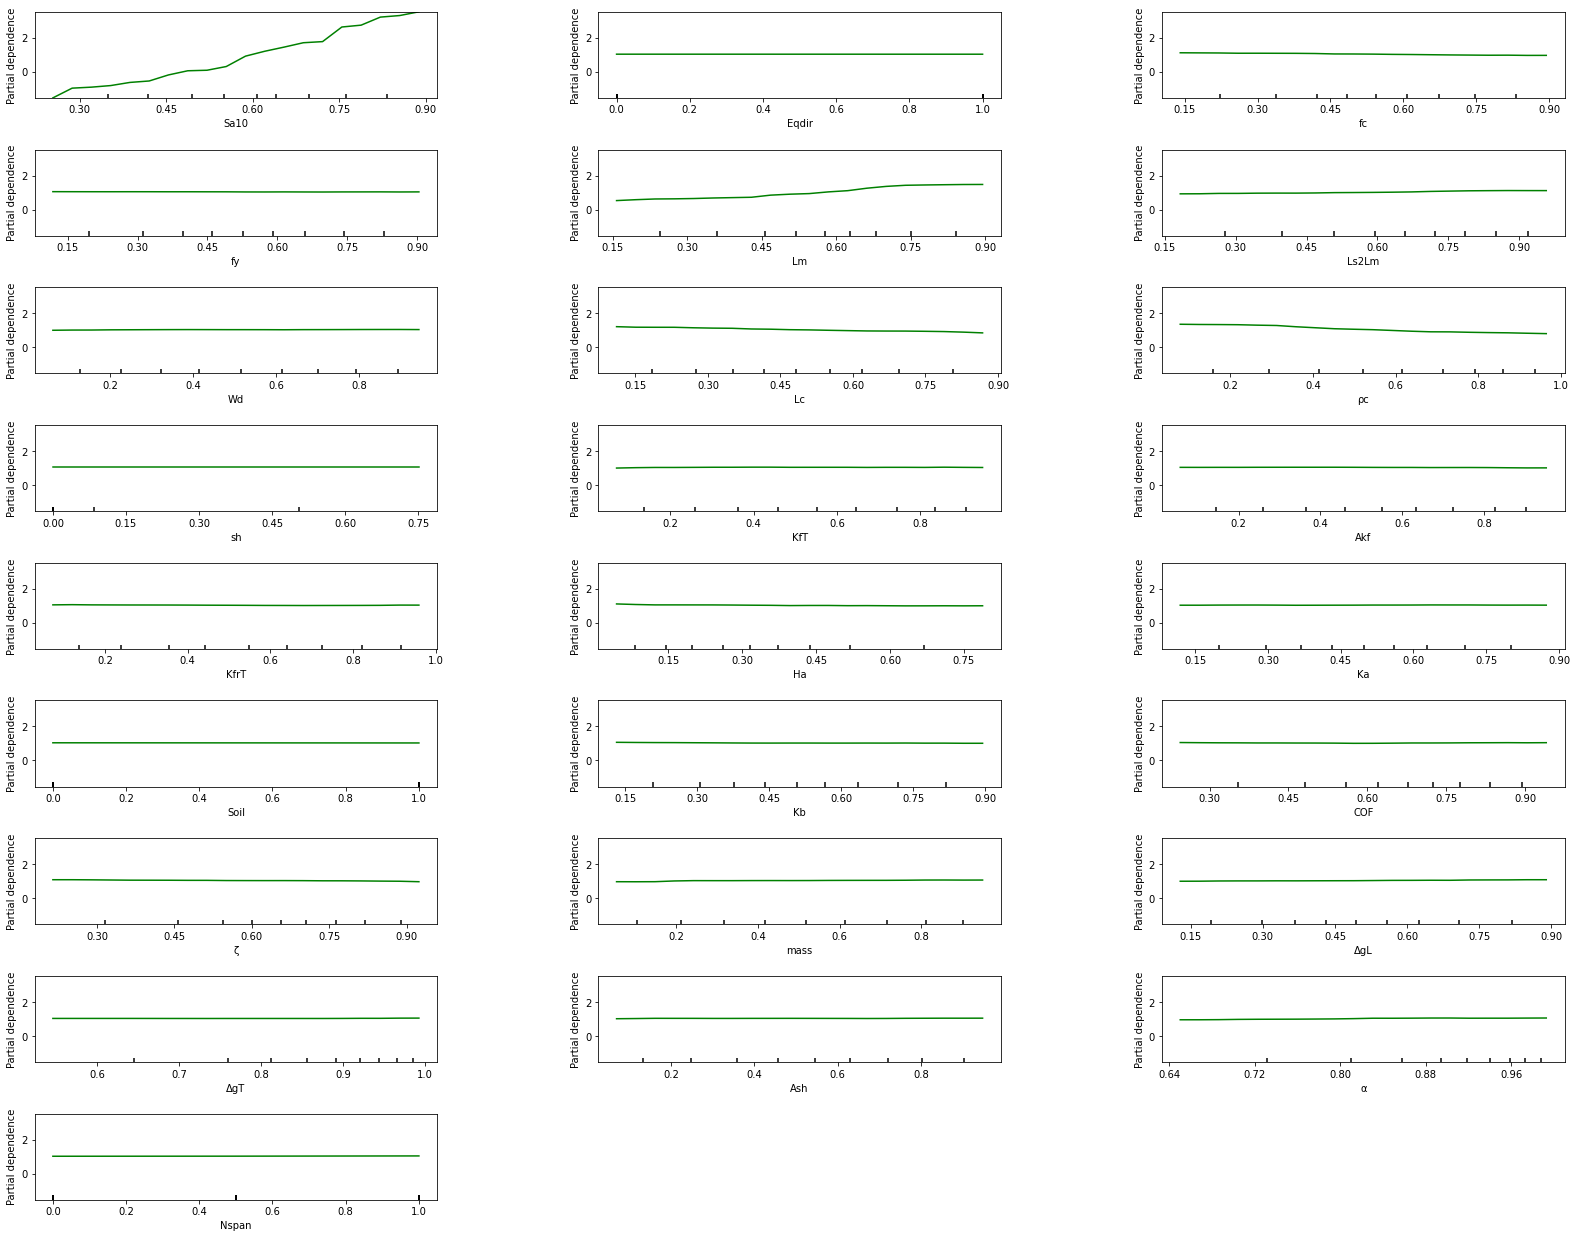

In [15]:
features = [i for i in range(0, len(X.columns))]  # Features used for computing and plotting PDPlot
plot_partial_dependence(XGB_model, X_train, features, feature_names, n_jobs=3, grid_resolution=20)
fig = plt.gcf()

fig.set_size_inches(25, 30)
fig.subplots_adjust(wspace=0.4,hspace=0.6)
plt.savefig('skew_bridge_PDP.eps',format='eps', dpi=1000)

# SHAP value

In [16]:
X_shap = scaler.transform(X)
X_shap = pd.DataFrame(X_shap, columns = X.columns)

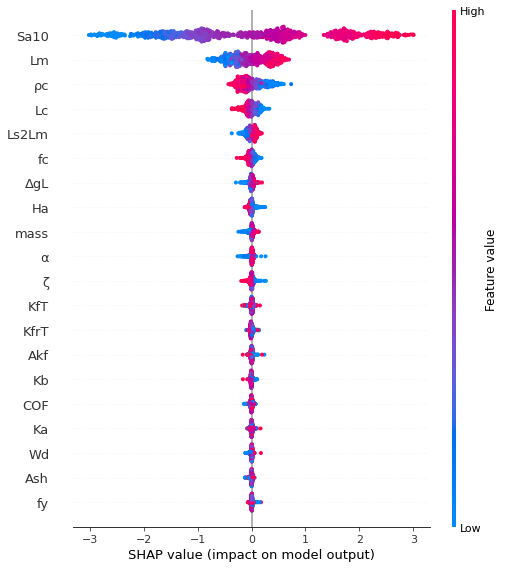

<Figure size 432x288 with 0 Axes>

In [17]:
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap)
plt.savefig('skew_bridge_SHAP_summary.eps',format='eps', dpi=1000)

In [18]:
# Single value explainer
shap.force_plot(explainer.expected_value, shap_values[0,:], X_shap.iloc[0,:])

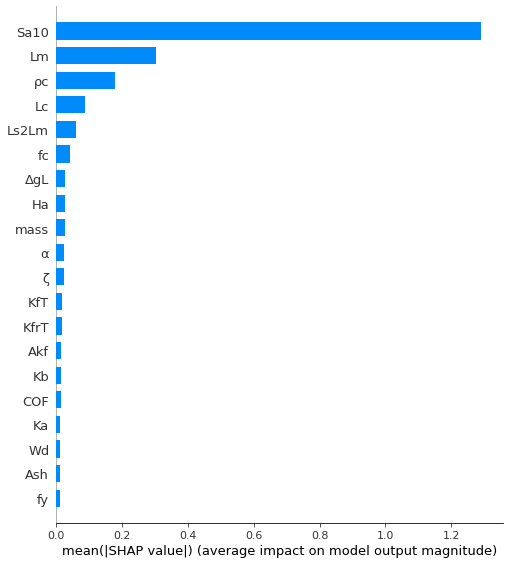

In [19]:
shap.summary_plot(shap_values, X_shap,  plot_type="bar", show=False)
plt.savefig('shear_wall_shap_barplot.eps',format='eps', dpi=1000)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


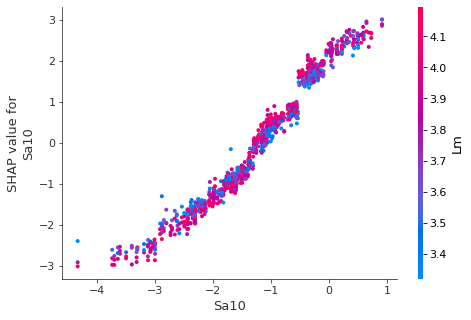

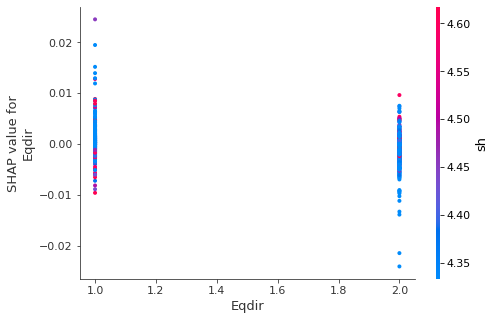

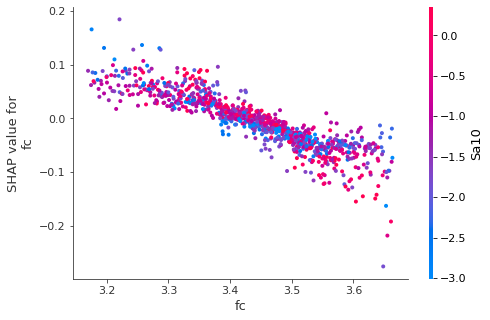

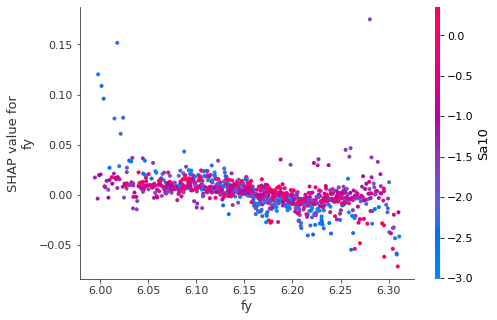

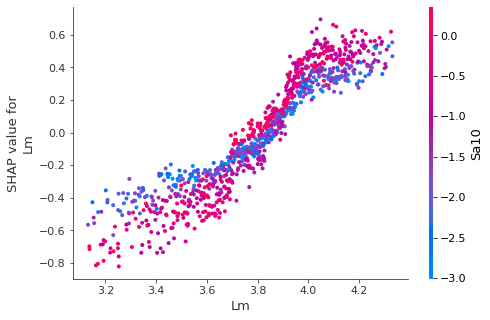

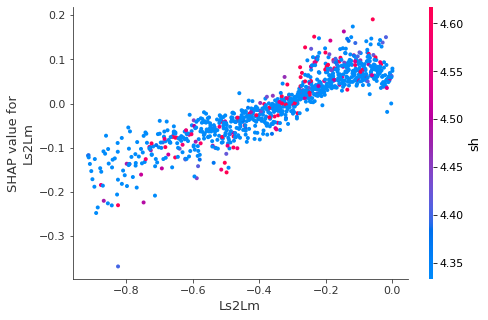

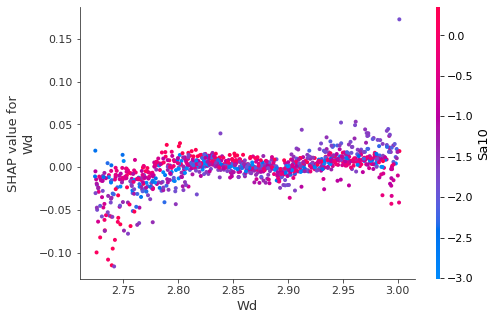

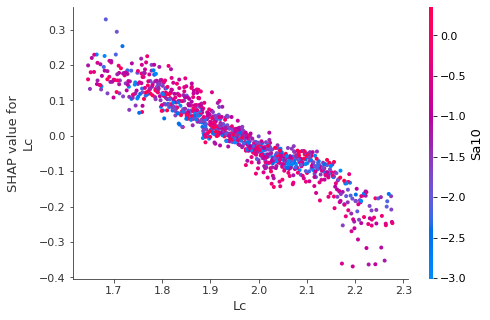

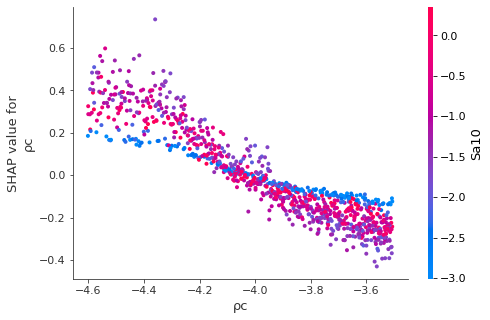

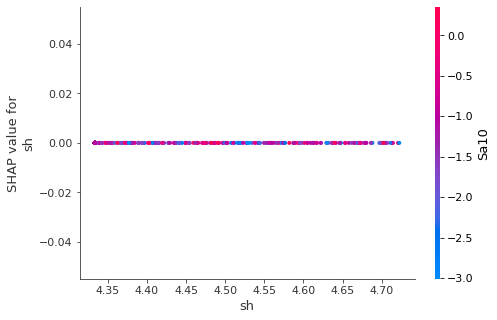

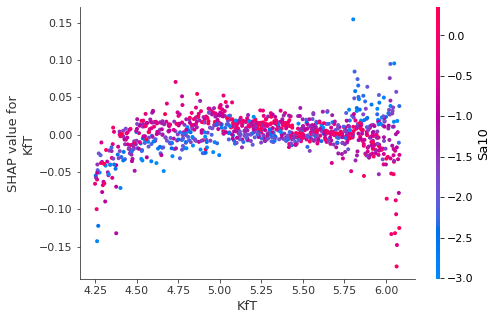

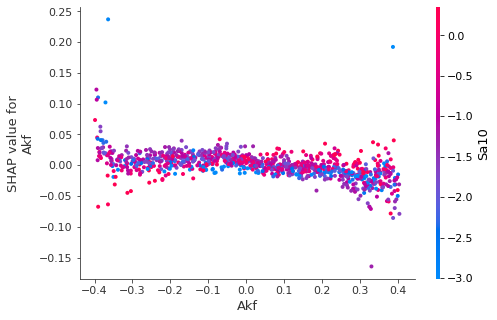

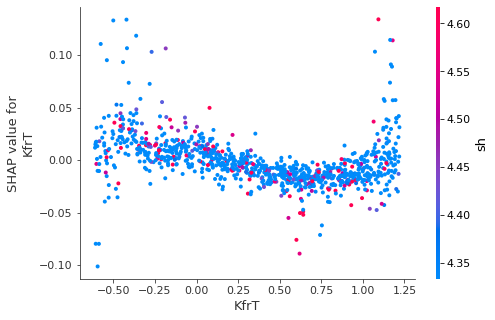

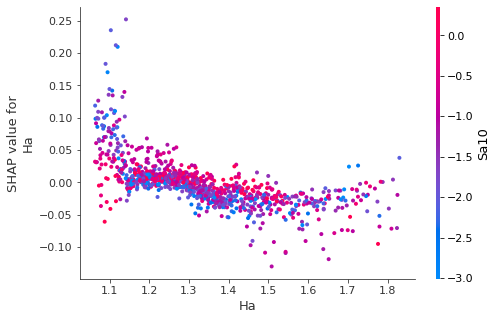

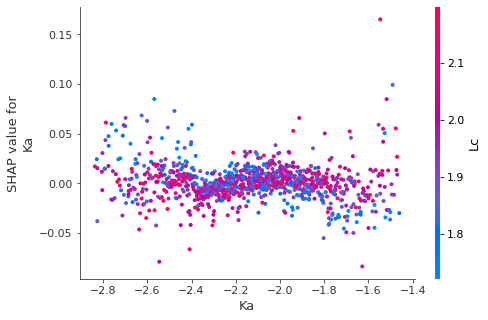

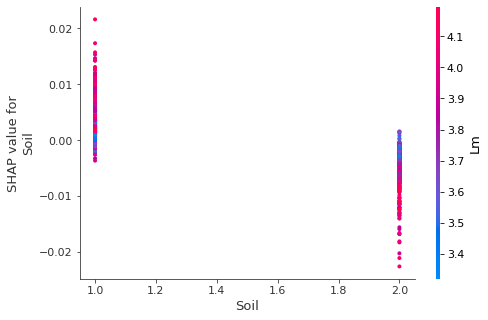

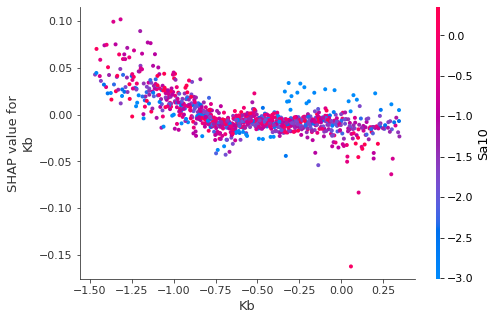

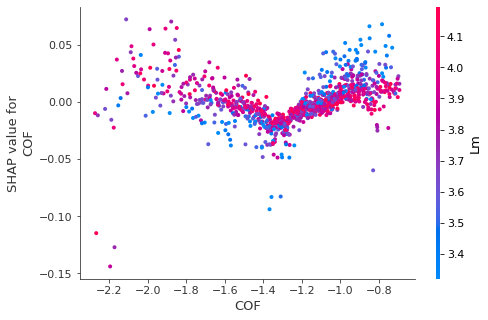

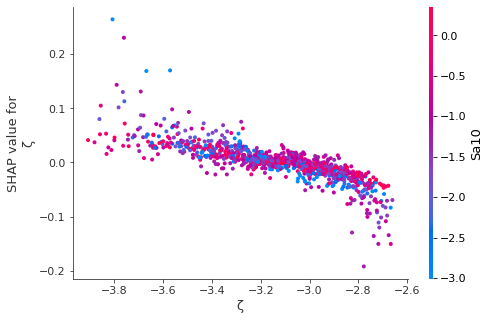

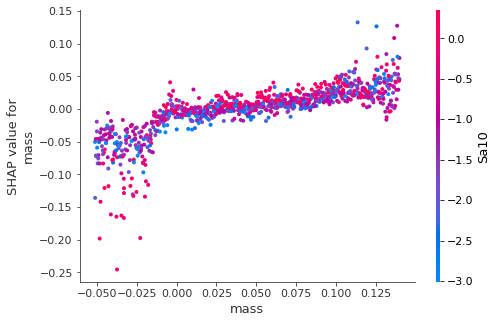

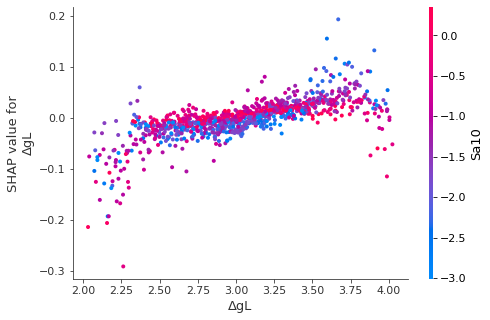

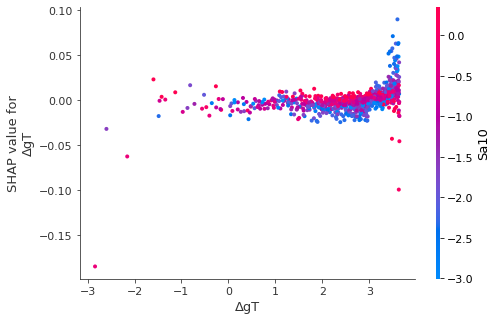

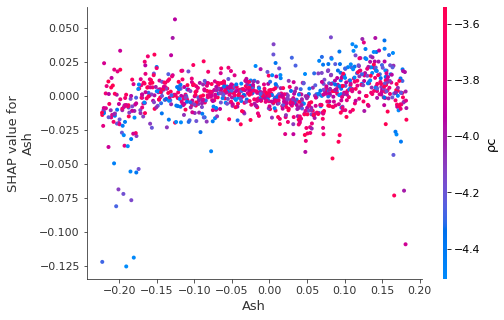

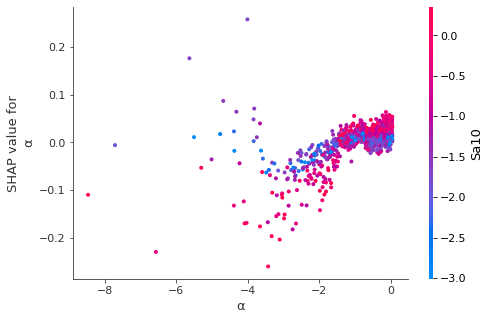

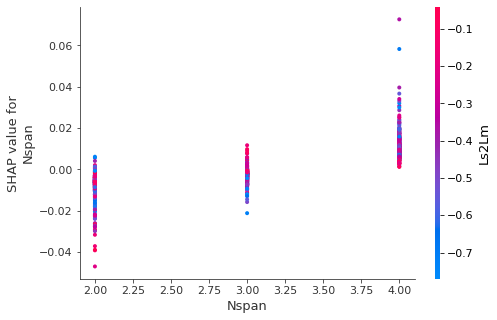

In [20]:
# Plot the dependance plot for class 0
n=1
for name in X_shap.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_shap, show=False )
    
    plt.savefig("Skew_bridge_dependance_" + str(n) +".eps", format="EPS")
    n=n+1


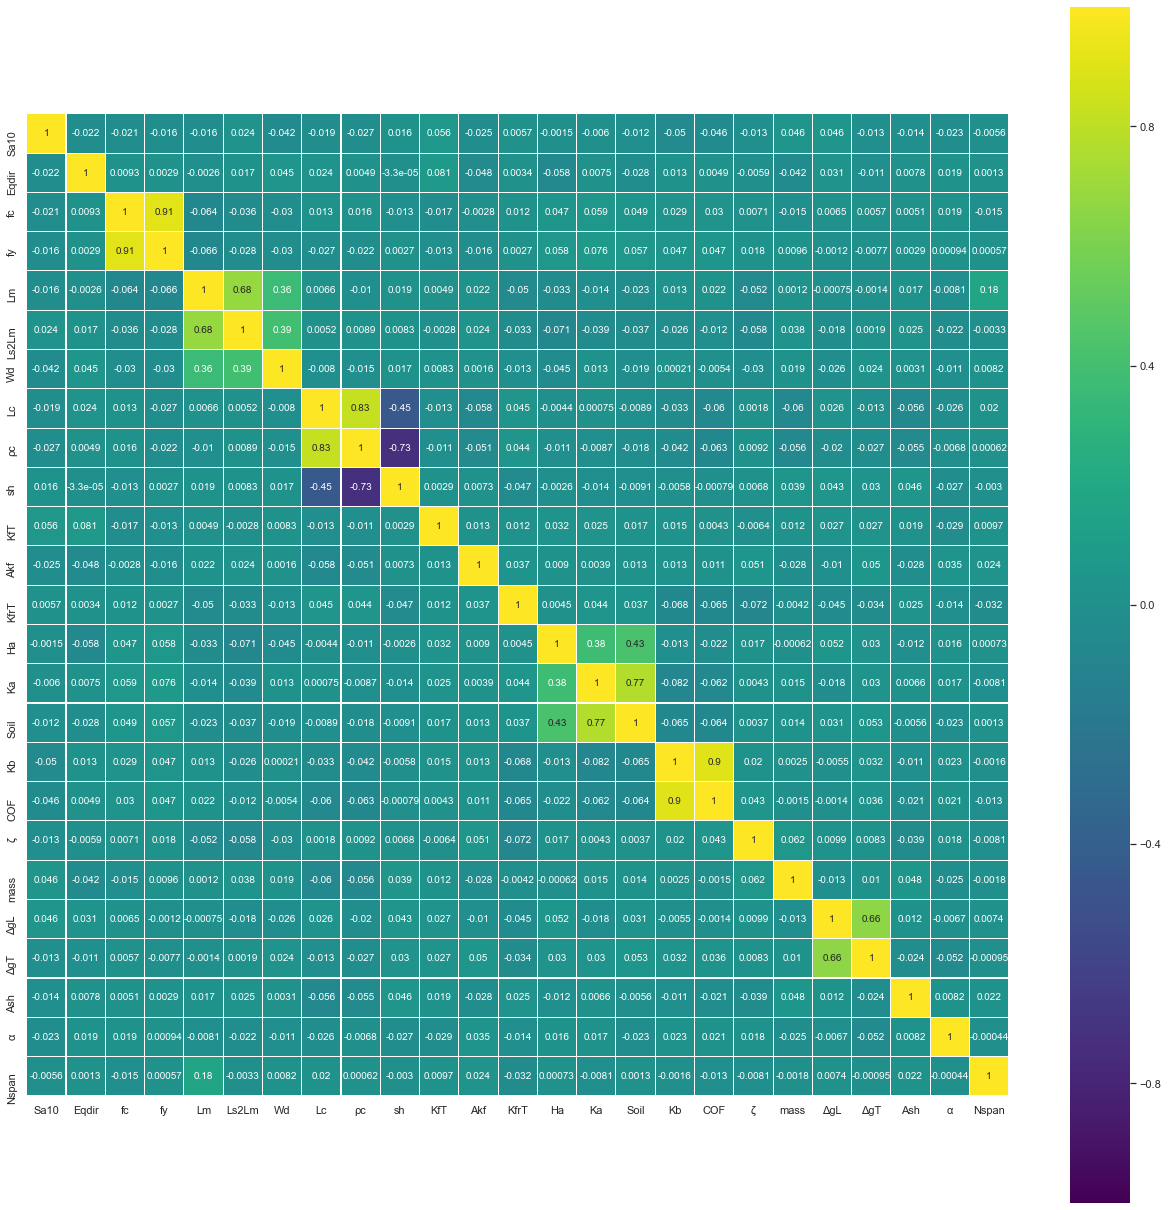

In [21]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

corr = data.drop('EDP', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(22, 22))

sns.heatmap(corr[(corr >= 0.0) | (corr <= -0.0)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);